In [1]:
#6->2->6

## Imports

In [2]:
import random

import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e1_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Get Data

In [4]:
input_data = get_dataset(img_width=8, img_height=8, train=True)
print("Original data set size:", len(input_data))

# Select only the pictures with numbers 0 or 1. (jus to compare with literature)
filtered_data = [image for image in input_data if image[1] in [0, 1]]
input_data = filtered_data
print("Final data set szize:", len(input_data))

Original data set size: 60000
Final data set szize: 12665


## Training node

In [5]:
shots = 2500
nr_trash=4
nr_latent=2
nr_ent=0
spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [6]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, *init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e1_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [7]:
epochs = 2000
learning_rate = 0.0003
batch_size = 5
num_samples = 20

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [8]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [9]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [10]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [11]:
def iterate_batches(X, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [12]:
training_data = [input_data[i] for i in range(num_samples)]
test_data = [input_data[i] for i in range(num_samples,num_samples+num_samples)]

In [13]:
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2

In [14]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = 2 * 3 * nr_encod_qubits + 3 * (nr_encod_qubits - 1) * nr_encod_qubits
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)


###  training

In [15]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.7786612553096124 | Fidelity:0.5622206010362156
Test-Epoch:0 | Loss:1.7990832569907458 | Fidelity:0.555838645106764
Epoch:5 | Loss:1.7683878403968412 | Fidelity:0.5654868107301569
Test-Epoch:5 | Loss:1.788510491867467 | Fidelity:0.5591244807045295
Epoch:10 | Loss:1.758209285664473 | Fidelity:0.5687605043116777
Test-Epoch:10 | Loss:1.7782344868257662 | Fidelity:0.5623555315165707
Epoch:15 | Loss:1.7480061733996703 | Fidelity:0.5720803594503991
Test-Epoch:15 | Loss:1.7680392283123159 | Fidelity:0.5655983102561313
Epoch:20 | Loss:1.7376841843763706 | Fidelity:0.575478564511931
Test-Epoch:20 | Loss:1.7577799193516934 | Fidelity:0.5688994333083637
Epoch:25 | Loss:1.727151506877376 | Fidelity:0.5789880019315519
Test-Epoch:25 | Loss:1.7473593969864478 | Fidelity:0.5722921121577117
Epoch:30 | Loss:1.7163072377538522 | Fidelity:0.5826462640271273
Test-Epoch:30 | Loss:1.7366522976368723 | Fidelity:0.5758205032525724
Epoch:35 | Loss:1.7050595059136384 | Fidelity:0.5864897949495086

Epoch:305 | Loss:1.1828418793892939 | Fidelity:0.8454215372525569
Test-Epoch:305 | Loss:1.1970220426017948 | Fidelity:0.8354065041496174
Epoch:310 | Loss:1.1788415167486053 | Fidelity:0.8482904493880794
Test-Epoch:310 | Loss:1.1931994402919306 | Fidelity:0.8380828604439653
Epoch:315 | Loss:1.1749763057882203 | Fidelity:0.851080992079377
Test-Epoch:315 | Loss:1.1895094420359154 | Fidelity:0.8406826920923314
Epoch:320 | Loss:1.1712416737037625 | Fidelity:0.8537947568393351
Test-Epoch:320 | Loss:1.1859472343552429 | Fidelity:0.8432078350801712
Epoch:325 | Loss:1.1676332471056698 | Fidelity:0.8564333042749512
Test-Epoch:325 | Loss:1.1825082604238584 | Fidelity:0.8456600545365835
Epoch:330 | Loss:1.1641468327174134 | Fidelity:0.8589981709315371
Test-Epoch:330 | Loss:1.1791881932518176 | Fidelity:0.8480410554674277
Epoch:335 | Loss:1.1607783984021403 | Fidelity:0.8614908766191218
Test-Epoch:335 | Loss:1.1759829097582668 | Fidelity:0.8503524938177536
Epoch:340 | Loss:1.1575240551777513 | Fide

Test-Epoch:605 | Loss:1.0946975074647263 | Fidelity:0.9134943609362537
Epoch:610 | Loss:1.073340394483162 | Fidelity:0.9316708894399925
Test-Epoch:610 | Loss:1.0939513335750528 | Fidelity:0.9141174468264344
Epoch:615 | Loss:1.07252289193513 | Fidelity:0.9323810312297592
Test-Epoch:615 | Loss:1.0932166691383356 | Fidelity:0.9147317528447422
Epoch:620 | Loss:1.0717140981271496 | Fidelity:0.9330846741192713
Test-Epoch:620 | Loss:1.0924933785941398 | Fidelity:0.9153373554417662
Epoch:625 | Loss:1.0709136676477302 | Fidelity:0.9337820873987978
Test-Epoch:625 | Loss:1.0917813405294567 | Fidelity:0.915934320250475
Epoch:630 | Loss:1.0701212727319027 | Fidelity:0.9344735269556033
Test-Epoch:630 | Loss:1.0910804436902253 | Fidelity:0.916522705345011
Epoch:635 | Loss:1.0693366012900678 | Fidelity:0.9351592368516904
Test-Epoch:635 | Loss:1.0903905831936727 | Fidelity:0.9171025643591623
Epoch:640 | Loss:1.068559355153688 | Fidelity:0.9358394507305332
Test-Epoch:640 | Loss:1.0897116569908445 | Fide

Epoch:910 | Loss:1.0329807322160665 | Fidelity:0.9680722677708499
Test-Epoch:910 | Loss:1.0643872773359602 | Fidelity:0.9395076597522717
Epoch:915 | Loss:1.0324344519111732 | Fidelity:0.9685844928449129
Test-Epoch:915 | Loss:1.0640684618432519 | Fidelity:0.93978915441938
Epoch:920 | Loss:1.0318954244649599 | Fidelity:0.9690904487908762
Test-Epoch:920 | Loss:1.0637565070786887 | Fidelity:0.9400647548057982
Epoch:925 | Loss:1.0313638967546255 | Fidelity:0.9695898830147949
Test-Epoch:925 | Loss:1.0634516033267725 | Fidelity:0.9403342821353803
Epoch:930 | Loss:1.0308401001633096 | Fidelity:0.9700825567821594
Test-Epoch:930 | Loss:1.0631539260831224 | Fidelity:0.9405975705551924
Epoch:935 | Loss:1.030324248868776 | Fidelity:0.9705682469357877
Test-Epoch:935 | Loss:1.0628636342278752 | Fidelity:0.9408544688110029
Epoch:940 | Loss:1.0298165384221643 | Fidelity:0.9710467473479806
Test-Epoch:940 | Loss:1.062580868509437 | Fidelity:0.9411048416510418
Epoch:945 | Loss:1.0293171446278593 | Fidelit

Epoch:1210 | Loss:1.013949678105438 | Fidelity:0.9862422382425301
Test-Epoch:1210 | Loss:1.0563483120130155 | Fidelity:0.9466574506039244
Epoch:1215 | Loss:1.013809063892985 | Fidelity:0.9863790289663041
Test-Epoch:1215 | Loss:1.0563123716383758 | Fidelity:0.9466896600377478
Epoch:1220 | Loss:1.0136715366612212 | Fidelity:0.9865128533585427
Test-Epoch:1220 | Loss:1.056276403814845 | Fidelity:0.946721896265412
Epoch:1225 | Loss:1.0135369903478435 | Fidelity:0.9866438122369882
Test-Epoch:1225 | Loss:1.0562403260381292 | Fidelity:0.946754233244358
Epoch:1230 | Loss:1.0134053217887458 | Fidelity:0.986772003757505
Test-Epoch:1230 | Loss:1.056204061224634 | Fidelity:0.9467867400931336
Epoch:1235 | Loss:1.0132764306938118 | Fidelity:0.9868975234283098
Test-Epoch:1235 | Loss:1.0561675375093196 | Fidelity:0.9468194812711486
Epoch:1240 | Loss:1.0131502196157274 | Fidelity:0.9870204641314546
Test-Epoch:1240 | Loss:1.056130688040311 | Fidelity:0.9468525167614782
Epoch:1245 | Loss:1.013026593912581

Test-Epoch:1505 | Loss:1.0530810935673185 | Fidelity:0.9495944862256461
Epoch:1510 | Loss:1.0085049872842151 | Fidelity:0.9915667375060607
Test-Epoch:1510 | Loss:1.0530025564779746 | Fidelity:0.9496653107327158
Epoch:1515 | Loss:1.008438446507821 | Fidelity:0.9916321650200433
Test-Epoch:1515 | Loss:1.0529234368554679 | Fidelity:0.9497366712497893
Epoch:1520 | Loss:1.0083722308471246 | Fidelity:0.9916972814294074
Test-Epoch:1520 | Loss:1.0528437507178017 | Fidelity:0.9498085535657367
Epoch:1525 | Loss:1.008306335662399 | Fidelity:0.9917620911734705
Test-Epoch:1525 | Loss:1.0527635144632561 | Fidelity:0.9498809431193503
Epoch:1530 | Loss:1.0082407571623997 | Fidelity:0.9918265978598282
Test-Epoch:1530 | Loss:1.0526827449041254 | Fidelity:0.9499538249684866
Epoch:1535 | Loss:1.008175492376807 | Fidelity:0.9918908042908953
Test-Epoch:1535 | Loss:1.0526014593028274 | Fidelity:0.9500271837570257
Epoch:1540 | Loss:1.008110539127699 | Fidelity:0.9919547124914331
Test-Epoch:1540 | Loss:1.052519

Epoch:1805 | Loss:1.0051784309791878 | Fidelity:0.9948482470180512
Test-Epoch:1805 | Loss:1.048201696346499 | Fidelity:0.9540148651595345
Epoch:1810 | Loss:1.0051327441490339 | Fidelity:0.9948934663815183
Test-Epoch:1810 | Loss:1.048137253581698 | Fidelity:0.9540735209847725
Epoch:1815 | Loss:1.0050872788479333 | Fidelity:0.9949384705637063
Test-Epoch:1815 | Loss:1.048073960076929 | Fidelity:0.954131137774475
Epoch:1820 | Loss:1.0050420202442003 | Fidelity:0.994983274188899
Test-Epoch:1820 | Loss:1.048011825031214 | Fidelity:0.9541877067753657
Epoch:1825 | Loss:1.0049969533631233 | Fidelity:0.9950278920285264
Test-Epoch:1825 | Loss:1.047950855701083 | Fidelity:0.9542432210058133
Epoch:1830 | Loss:1.00495206314082 | Fidelity:0.9950723389478465
Test-Epoch:1830 | Loss:1.0478910574156581 | Fidelity:0.9542976752432942
Epoch:1835 | Loss:1.0049073344777395 | Fidelity:0.9951166298529504
Test-Epoch:1835 | Loss:1.04783243359728 | Fidelity:0.9543510660067394
Epoch:1840 | Loss:1.0048627522917353 |

## Rezults

In [16]:
import matplotlib.pyplot as plt

fidelity: 0.9965236034936694


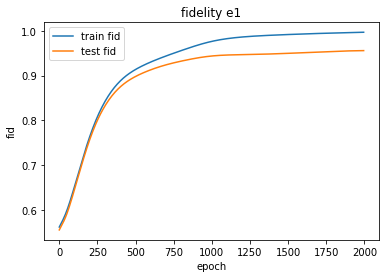

In [17]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")


plt.legend()
plt.title("fidelity e1",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0034885239989726


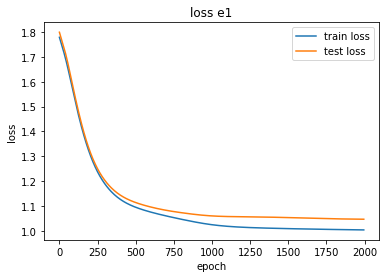

In [18]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("loss e1",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [ ]:
name = "training_e1"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples": num_samples,
                    "batch_size": batch_size,
                    "nr_layers": 1,
                    "epochs": epochs,
                    "learning_rate":learning_rate ,
                    "beta1":beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

66095